## PREPARE

LIBRARIES

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.sql.functions import lit
from bs4 import BeautifulSoup
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.sql.functions import when
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from datetime import datetime
from pyspark.ml import Transformer
from pyspark.sql.types import FloatType
from pyspark.ml.param.shared import HasInputCol, HasOutputCol 
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

SPARK

In [3]:
spark = SparkSession.builder.appName('Rating').getOrCreate()

### LOAD AND SHOW INFORMATION ABOUT DATA

In [4]:
df1 = spark.read.csv("comments_final2.csv", header=True, inferSchema=True)

In [5]:
df1.printSchema()

root
 |-- Column1: integer (nullable = true)
 |-- processed_text: string (nullable = true)
 |-- class: string (nullable = true)
 |-- word_count: integer (nullable = true)



In [6]:
df2 = df1.withColumn("class", when(df1['class'] == "negative","negative") \
      .when(df1['class'] == "neutral","negative") \
      .otherwise(df1['class']))
df2.show()

+-------+--------------------+--------+----------+
|Column1|      processed_text|   class|word_count|
+-------+--------------------+--------+----------+
|    601| sách không_đối thần|negative|         3|
|   3070|  tuyệt_đối lượm lỗi|negative|         3|
|   3370|        chữ đọc dịch|negative|         3|
|   3784|  quá_thất vọng hàng|negative|         3|
|   3881|      bì bị_nhăn góc|negative|         3|
|   4022|       đường ướt mưa|negative|         3|
|   4393| bị_lặp cẩu_thả khâu|negative|         3|
|   4755|    tâm chán quá_mặc|negative|         3|
|   5030|    sách hơi_quăn ổn|negative|         3|
|   5419|  sách lỗi không_đẹp|negative|         3|
|   5425|      đọc bị_mấy vết|negative|         3|
|   5966|       sách bọc lông|negative|         3|
|   6100|không_hiểu bị_lỗi...|negative|         3|
|   7297|   sách bị_dẹp bị_dơ|negative|         3|
|   7427|      sách đọc trắng|negative|         3|
|   7815|     gói hàng làm_ăn|negative|         3|
|   8137|   hàng quá_buồn săn|n

In [7]:
df2.count()

36932

In [8]:
df2.groupby('class').count().show()

+--------+-----+
|   class|count|
+--------+-----+
|positive|27643|
|negative| 9289|
+--------+-----+



### CHECK DATA

In [9]:
df2 = df2.withColumn('length', length(df2['processed_text']))

In [10]:
df2.show(5)

+-------+-------------------+--------+----------+------+
|Column1|     processed_text|   class|word_count|length|
+-------+-------------------+--------+----------+------+
|    601|sách không_đối thần|negative|         3|    19|
|   3070| tuyệt_đối lượm lỗi|negative|         3|    18|
|   3370|       chữ đọc dịch|negative|         3|    12|
|   3784| quá_thất vọng hàng|negative|         3|    18|
|   3881|     bì bị_nhăn góc|negative|         3|    14|
+-------+-------------------+--------+----------+------+
only showing top 5 rows



In [11]:
df2.groupBy('class').mean().show()

+--------+-----------------+------------------+------------------+
|   class|     avg(Column1)|   avg(word_count)|       avg(length)|
+--------+-----------------+------------------+------------------+
|positive|39626.48019390081| 17.43736208081612|109.52154252432804|
|negative|40433.18817956723|13.553450317579934| 82.41619119388524|
+--------+-----------------+------------------+------------------+



In [12]:
data = df2.select('processed_text','class','length')

In [13]:
data.show()

+--------------------+--------+------+
|      processed_text|   class|length|
+--------------------+--------+------+
| sách không_đối thần|negative|    19|
|  tuyệt_đối lượm lỗi|negative|    18|
|        chữ đọc dịch|negative|    12|
|  quá_thất vọng hàng|negative|    18|
|      bì bị_nhăn góc|negative|    14|
|       đường ướt mưa|negative|    13|
| bị_lặp cẩu_thả khâu|negative|    19|
|    tâm chán quá_mặc|negative|    16|
|    sách hơi_quăn ổn|negative|    16|
|  sách lỗi không_đẹp|negative|    18|
|      đọc bị_mấy vết|negative|    14|
|       sách bọc lông|negative|    13|
|không_hiểu bị_lỗi...|negative|    22|
|   sách bị_dẹp bị_dơ|negative|    17|
|      sách đọc trắng|negative|    14|
|     gói hàng làm_ăn|negative|    15|
|   hàng quá_buồn săn|negative|    17|
|     bị_mốp bìa cười|negative|    15|
|   căng rất_thư giãn|negative|    17|
|sản_phẩm rất_tệ t...|negative|    21|
+--------------------+--------+------+
only showing top 20 rows



### RESAMPLING

In [14]:
from pyspark.sql.functions import col, explode, array, lit
major_df = data.filter(col("class") == 'positive')
minor_df = data.filter(col("class") == 'negative')
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))


ratio: 2


In [15]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(minor_df)
combined_df_2.show()

+--------------------+--------+------+
|      processed_text|   class|length|
+--------------------+--------+------+
|cực_kì chất_lượng...|positive|    29|
|sản_phẩm hàng hài...|positive|    29|
| nhiên sách màng bọc|positive|    19|
|nội hấp_dẫn dịch_...|positive|    24|
| sách đẹp bọc rất_kĩ|positive|    19|
|hàng chất_lượng s...|positive|    24|
|sách học kỹ không_bị|positive|    20|
|sách đóng gáy khô...|positive|    23|
|hàng sách dễ_thươ...|positive|    23|
|truyện hơi_ít bé ...|positive|    22|
|   sách đẹp nội hàng|positive|    17|
|sách truyện_ngắn ...|positive|    22|
|hơi_chậm nêu hết_...|positive|    25|
|hàng đóng_gói cẩn...|positive|    27|
|đóng gói sản_phẩm...|positive|    22|
|sản_phẩm cực_kỳ h...|positive|    26|
|hàng bị_móp nhẹ sách|positive|    20|
|hàng sách tổng_hợ...|positive|    28|
|     gói nội chờ đọc|positive|    15|
|rất_tuyệt vời hìn...|positive|    30|
+--------------------+--------+------+
only showing top 20 rows



In [16]:
combined_df_2.groupby('class').count().show()

+--------+-----+
|   class|count|
+--------+-----+
|positive|13665|
|negative| 9289|
+--------+-----+



### FEATURES AND TRANSFORM

In [17]:
class BsTextExtractor(Transformer, HasInputCol, HasOutputCol):
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(BsTextExtractor, self).__init__() 
        kwargs = self._input_kwargs 
        self.setParams(**kwargs)
        
    @keyword_only
    def setParams(self, inputCol=None, outputCol=None): 
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    def _transform(self, dataset):
        def f(s):
            cleaned_text = BeautifulSoup(s).text 
            return cleaned_text
        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [18]:
text_extractor = BsTextExtractor(inputCol="processed_text", outputCol="cleaned_text")
tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='token_text')
stopremove= StopWordsRemover(inputCol='token_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
ham_spam_to_num = StringIndexer(inputCol='class',outputCol='label', handleInvalid='keep')

In [19]:
clean_up = VectorAssembler(inputCols =['tf_idf','length'],
                           outputCol='features')

In [20]:
data_prep_pipe = Pipeline(stages=[ham_spam_to_num,
                                  text_extractor,
                                  tokenizer,
                                  stopremove,
                                  count_vec,
                                  idf,
                                  clean_up])

In [21]:
cleaner = data_prep_pipe.fit(combined_df_2)

In [22]:
clean_data = cleaner.transform(combined_df_2)

In [23]:
clean_data = clean_data.select('label','features')

In [24]:
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(18198,[9,26,136,...|
|  0.0|(18198,[2,23,81,1...|
|  0.0|(18198,[0,6,29,21...|
|  0.0|(18198,[2,3,86,14...|
|  0.0|(18198,[0,4,6,746...|
|  0.0|(18198,[0,2,9,11,...|
|  0.0|(18198,[0,21,26,9...|
|  0.0|(18198,[0,18,48,4...|
|  0.0|(18198,[0,2,13,28...|
|  0.0|(18198,[15,19,56,...|
|  0.0|(18198,[0,2,3,4,1...|
|  0.0|(18198,[0,56,1095...|
|  0.0|(18198,[530,1302,...|
|  0.0|(18198,[0,2,8,25,...|
|  0.0|(18198,[12,18,23,...|
|  0.0|(18198,[23,159,23...|
|  0.0|(18198,[0,2,75,16...|
|  0.0|(18198,[0,2,38,58...|
|  0.0|(18198,[1,3,12,16...|
|  0.0|(18198,[91,277,47...|
+-----+--------------------+
only showing top 20 rows



In [25]:
clean_data.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|13665|
|  1.0| 9289|
+-----+-----+



In [26]:
(train, test) = clean_data.randomSplit([0.7,0.3])

## BUILD MODEL AND TEST

### Naive Bayes

In [27]:
nb = NaiveBayes()
prediction = nb.fit(train)
test_results = prediction.transform(test)
start_time = datetime.now()
train_time = datetime.now() - start_time  
test_results.show()
print(train_time)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(18198,[0,1,2,3,4...|[-533.95327155323...|[0.99963903593602...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-758.73930365562...|[1.55614872602248...|       1.0|
|  0.0|(18198,[0,1,2,3,4...|[-412.22696694130...|[0.99999999999998...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-568.58879181513...|[0.99999090663776...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-936.41722198824...|[1.0,7.1291481945...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-834.01200304761...|[1.0,4.0787005624...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-1205.2793672983...|[0.99999999940415...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-367.75978648172...|[0.99999935943451...|       0.0|
|  0.0|(18198,[0,1,2,3,4...|[-367.75978648172...|[0.99999935943451...|       0.0|
|  0.0|(18198,[0

In [28]:
test_results.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  977|
|  0.0|       0.0| 3167|
|  1.0|       1.0| 2292|
|  1.0|       0.0|  482|
+-----+----------+-----+



### Report

In [29]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = test_results.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

c:\ProgramData\anaconda3\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[3167.  977.]
 [ 482. 2292.]]


              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81      4144
         1.0       0.70      0.83      0.76      2774

    accuracy                           0.79      6918
   macro avg       0.78      0.80      0.79      6918
weighted avg       0.80      0.79      0.79      6918



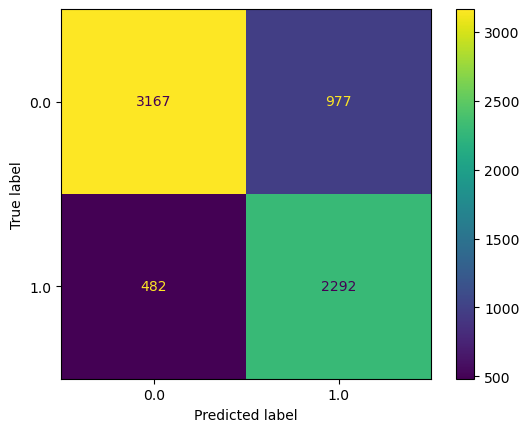

In [35]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(preds_and_labels.toPandas()['label'], preds_and_labels.toPandas()['prediction']))
ConfusionMatrixDisplay.from_predictions(preds_and_labels.toPandas()['label'], preds_and_labels.toPandas()['prediction'])

In [30]:
acc_eva = MulticlassClassificationEvaluator()
acc = acc_eva.evaluate(test_results)
print('Accuracy of model: {}'.format(acc))

Accuracy of model: 0.7910405790170008


### Logistic Regression

In [31]:
lg = LogisticRegression(maxIter=10, regParam=0.3)
pre_lg = lg.fit(train)
result_lg = pre_lg.transform(test)
start_time = datetime.now()
train_time = datetime.now() - start_time 
print(train_time)

0:00:00


In [32]:
result_lg.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  416|
|  0.0|       0.0| 3728|
|  1.0|       1.0| 1993|
|  1.0|       0.0|  781|
+-----+----------+-----+



### Report

In [33]:
#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels_lg = result_lg.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels_lg = preds_and_labels_lg.select(['prediction','label'])

metrics_lg = MulticlassMetrics(preds_and_labels_lg.rdd.map(tuple))
print(metrics_lg.confusionMatrix().toArray())

c:\ProgramData\anaconda3\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[3728.  416.]
 [ 781. 1993.]]


              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      4144
         1.0       0.83      0.72      0.77      2774

    accuracy                           0.83      6918
   macro avg       0.83      0.81      0.82      6918
weighted avg       0.83      0.83      0.82      6918



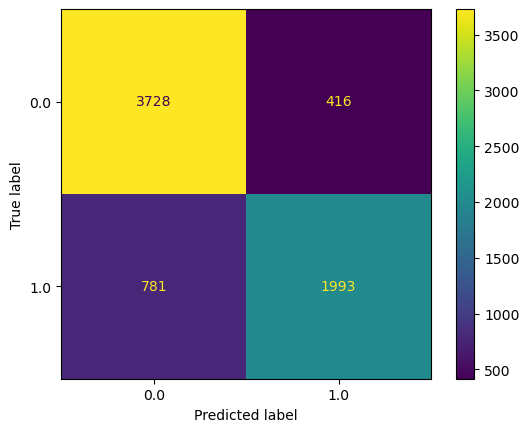

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(preds_and_labels_lg.toPandas()['label'], preds_and_labels_lg.toPandas()['prediction']))
ConfusionMatrixDisplay.from_predictions(preds_and_labels_lg.toPandas()['label'], preds_and_labels_lg.toPandas()['prediction'])

In [34]:
acc_eva_lg = MulticlassClassificationEvaluator()
acc_lg = acc_eva_lg.evaluate(result_lg)
print('Accuracy of model: {}'.format(acc_lg))

Accuracy of model: 0.8245299192195686
